Welcome to the 30 minutes Flower federated learning tutorial!

In this tutorial you will implement your first Federated Learning project using Flower.

🧑‍🏫 This tutorial starts at zero and expects no familiarity with federated learning. Only a basic understanding of data science and Python programming is assumed. A minimal understanding of ML is not required but if you already know abou it, nothing is stopping your from modifying this code as you see fit!

> Star Flower on [GitHub ⭐️](https://github.com/adap/flower) and join the Flower community on Slack to connect, ask questions, and get help: [Join Slack 🌼](https://flower.dev/join-slack/). We'd love to hear from you in the #introductions channel! And if anything is unclear, head over to the #questions channel.

Let's get stated!

# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab. Let's first, install Flower, then the ML framework of your choice and extra dependencies you might want to use.

## Installing Flower

You can install flower very conveniently from `pip`:

We will be using the _simulation_ model in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the [Virtual Client Engine]() in Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everyting transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.

## Install your ML framework

Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart_ example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory.

In this tutorial we are going to use PyTorch, so let's install a recent version. In this tutorial we'll use a small model so using CPU only training will suffice (this will also prevent Colab from abrumptly terminating your experiment if resource limits are exceeded)

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset.

In [30]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from typing import List, Tuple
from flwr.common import Metrics

def get_mnist(data_path: str = './data'):
    '''This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. WE construct the train/test
    split by converting the images into tensors and normalising them'''

    # transformation to conver images to tensors and apply normailsation
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

Let's run the code above and do some visualisations to understand better the data we are working with !

In [2]:
trainset, testset = get_mnist()

We can have a quick overview of our datasets by just typing the object on the command line. For instance, below you can see that the `trainset` has 60k training examples and will use the transformation rule we defined above in `get_mnist()`.

In [3]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

Text(0.5, 1.0, 'Class labels distribution for MNIST')

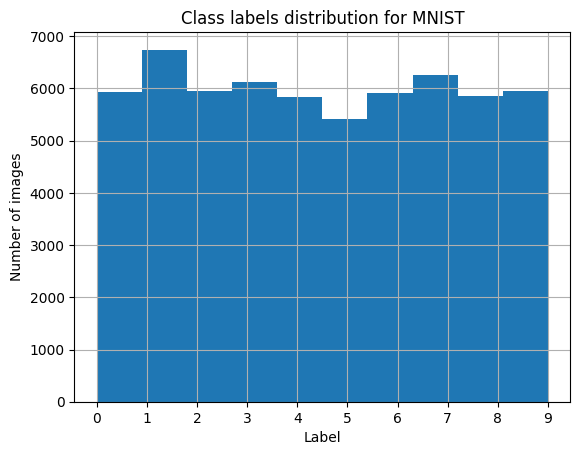

In [4]:
import matplotlib.pyplot as plt


# construct histogram
all_labels = trainset.targets
num_possible_labels = len(set(all_labels.numpy().tolist())) # this counst unique labels (so it should be = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

In [5]:
import random
import numpy as np

def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
  # take n examples at random
  idx =list(range(len(trainset_.data)))
  random.shuffle(idx)
  idx = idx[:n]
  if verbose:
    print(f"will display images with idx: {idx}")


  # construct canvas
  num_cols = 8
  num_rows = int(np.ceil(len(idx)/num_cols))
  fig, axs = plt.subplots(figsize=(16, num_rows*2), nrows=num_rows, ncols=num_cols)

  # display images on canvas
  for c_i, i in enumerate(idx):
    axs.flat[c_i].imshow(trainset_.data[i], cmap='gray')

Let's visualise 32 images from the dataset


will display images with idx: [56327, 43999, 21917, 32382, 32415, 7175, 10656, 38892, 52724, 17032, 52964, 10886, 29288, 28761, 37623, 1293, 24707, 7554, 47321, 30400, 27374, 7835, 8014, 50496, 53644, 4003, 593, 24828, 9235, 50959, 52242, 29870]


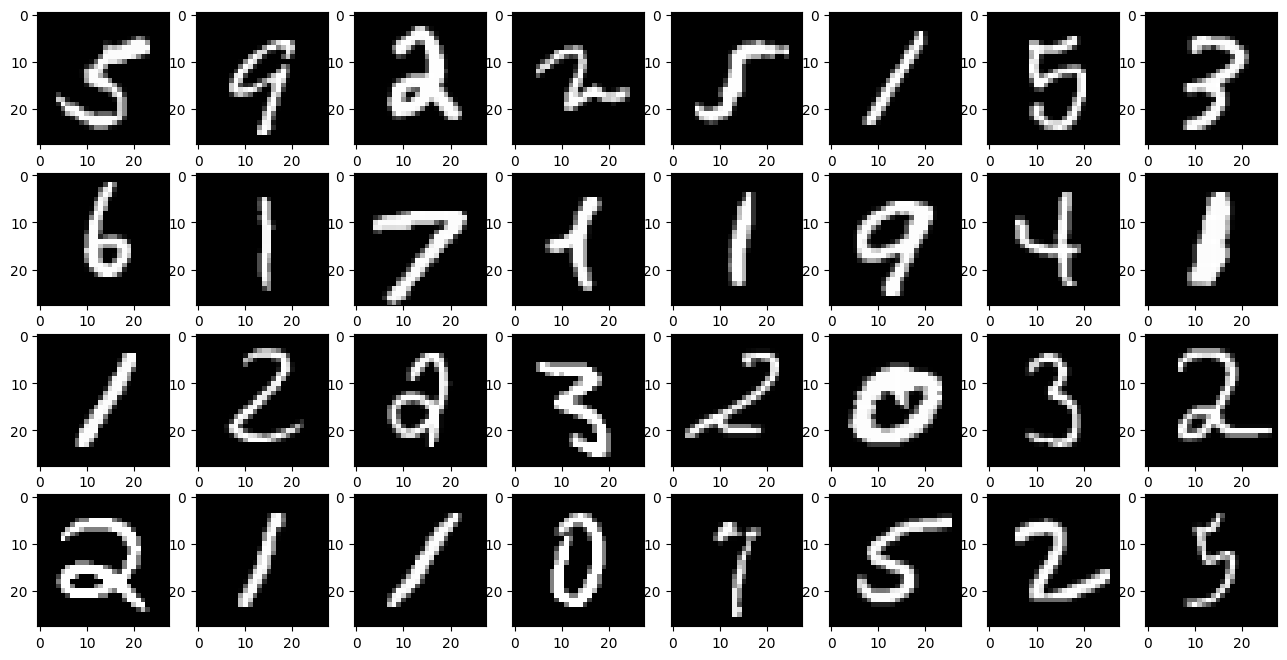

In [6]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anytning new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

# A CNN architecture

Thist tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification taks.



In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

In [8]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


In [9]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
   
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float=0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist()
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [10]:
run_centralised(epochs=5, lr=0.01)

loss = 2.8381582802176126
accuracy = 0.9883


The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To acomplish this with the MNIST dataset, we are going to generate N random paritions, where N is the total number of clients in our FL system.

In [11]:
from torch.utils.data import random_split

def prepare_dataset(num_partitions: int,
                    batch_size: int,
                    val_ratio: float = 0.1):

    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininsetg partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model. """

    # get the MNIST datatset
    trainset, testset = get_mnist()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(trainset, partition_len, torch.Generator().manual_seed(2023))

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(trainset_, [num_train, num_val], torch.Generator().manual_seed(2023))

        trainloaders.append(DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2))
        valloaders.append(DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2))

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

Let's create 100 partitions and extract some statistics from one partition


trainloaders
5
[<torch.utils.data.dataloader.DataLoader object at 0x00000197357C1120>, <torch.utils.data.dataloader.DataLoader object at 0x00000197357C3430>, <torch.utils.data.dataloader.DataLoader object at 0x00000197357640D0>, <torch.utils.data.dataloader.DataLoader object at 0x0000019735767D60>, <torch.utils.data.dataloader.DataLoader object at 0x000001973533C190>]
number of images: 10800


Text(0.5, 1.0, 'Class labels distribution for MNIST')

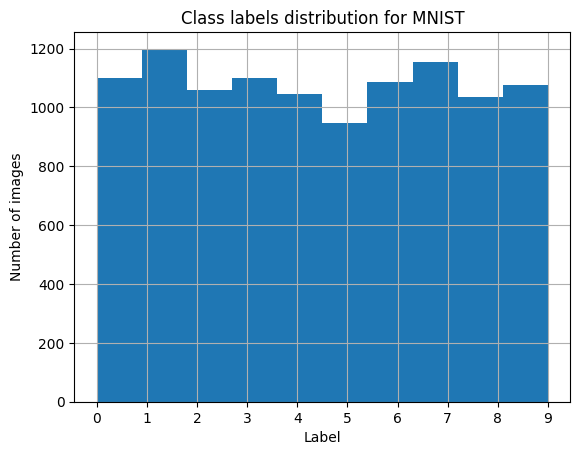

In [12]:
trainloaders, valloaders, testloader = prepare_dataset(num_partitions=5,
                                                       batch_size=32)
print("trainloaders")
print(len(trainloaders))
print(trainloaders)
# first partition
train_partition = trainloaders[0].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=10)
plt.grid()
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of images')
plt.title('Class labels distribution for MNIST')

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginnig where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

Let's next define how our FL clients will behave

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simmple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the lcoal model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

In [13]:
import flwr as fl

Now let's defice our Flower Client class:

In [24]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar

class FlowerClient(fl.client.NumPyClient):
    def __init__(self,
                 trainloader,
                 vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = Net(num_classes=10)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentaillly the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentaillly the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        
        # send statistics back to the server
        return float(loss), len(self.valloader), {'accuracy': accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keeneyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking baout the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Chosing a Flower Strategy


A strategy sits at the core of the Federated Learining experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and exectue global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be avaialable in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derieves a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

Let's see how we can define `FedAvg` using Flower. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify teh `evaluate_fn` arguemtn in your strategy, then, centralised global evaluation won't be perfromed.

In [33]:
#This function is used to obtain the values of accuracy when we evaluate the global model in validation local dataset
#We need to define how aggregate these accuracies

#the evaluate_function return the following   
#return float(loss), len(self.valloader), {'accuracy': accuracy}
# As we can see, it returns the len of the validation dataloader and the accuracy 
# we need to average the accuracy of the validation dataset of each local 

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]  #append the accuracy value for each local validation
    examples = [num_examples for num_examples, _ in metrics]  #append the length of each local validation

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}  # sum up all the accuracies in each node and divided for all number of datasamples sum

In [35]:
def get_evalulate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be exectued by the strategy
    at the end of each round to evaluate the stat of the global
    model."""
    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(model, testloader) # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


#GLOBAL DATASET FOR EVALUATION
#In this case, we have a global dataset for validation. For this reason, we use evaluate_fn function
# now we can define the strategy
# strategy = fl.server.strategy.FedAvg(fraction_fit=1, # let's sample 10% of the client each round to do local training
#                                       fraction_evaluate=1, # after each round, let's sample 20% of the clients to asses how well the global model is doing
#                                       min_available_clients=4, # total number of clients available in the experiment
#                                       evaluate_fn=get_evalulate_fn(testloader)) # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset




#LOCAL EVALUATION 
#It means that we have one local validation dataset. We obtain the accuracy in each local validation dataset evaluated in the global model
# now we can define the strategy
strategy = fl.server.strategy.FedAvg(fraction_fit=1, # let's sample 10% of the client each round to do local training
                                      fraction_evaluate=1, # after each round, let's sample 20% of the clients to asses how well the global model is doing
                                      min_available_clients=4, # total number of clients available in the experiment
                                      evaluate_metrics_aggregation_fn=weighted_average)  # We pass to the simulation the accuracy concatenation strategy) # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset


So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [36]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(trainloader=trainloaders[int(cid)],
                            vallodaer=valloaders[int(cid)])
    return client_fn

client_fn_callback = generate_client_fn(trainloaders, valloaders)

Now we are ready to launch the FL experiment using Flower simulation:

In [37]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback, # a callback to construct a client
    num_clients=5, # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=10), # let's run for 10 rounds
    strategy=strategy,# the strategy that will orchestrate the whole FL pipeline
    
)

INFO flwr 2023-07-19 16:04:27,618 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-07-19 16:04:34,361	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-19 16:04:35,933 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:127.0.0.1': 1.0, 'object_store_memory': 1851527577.0, 'memory': 3703055156.0, 'GPU': 1.0, 'CPU': 20.0}
INFO flwr 2023-07-19 16:04:35,933 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-19 16:04:35,933 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2023-07-19 16:04:37,427 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-19 16:04:37,431 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-07-19 16:04:37,432 | server.py:101 | FL starting
DEBUG flwr 2023-07-19 16:04:37,433 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
DEBUG flwr 2023-07-19 16:04:47,378 | server.py:2

In [38]:
print(history)

History (loss, distributed):
	round 1: 5.549656161665917
	round 2: 3.557259488850832
	round 3: 2.752342705463525
	round 4: 2.5418825172120707
	round 5: 2.1625266354880295
	round 6: 1.9544522522133776
	round 7: 1.962731930229347
	round 8: 1.8266275670786853
	round 9: 1.646109349199105
	round 10: 1.6674308810208458
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9545000000000001), (2, 0.9738333333333332), (3, 0.9800000000000001), (4, 0.9813333333333334), (5, 0.9840000000000001), (6, 0.985), (7, 0.9853333333333334), (8, 0.9858333333333333), (9, 0.9866666666666667), (10, 0.9871666666666666)]}


Doing 10 rounds should take less than 2 minutes on a CPU-only Colab instance <-- Flower Simulation is fast! 🚀

You can then use the resturned `History` object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtainined at the end of each round (including at the very beginning of the experiment) for the _global model_. This is want the function `evaluate_fn()` that we passed to the strategy reports.

In [25]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized['accuracy']
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0*data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel('Accuracy (%)')
plt.xlabel('Round')
plt.title('MNIST - IID - 5 clients')

history.metrics_centralized = {}


KeyError: 'accuracy'